In [1]:
import torch
import torch.nn as nn

In [2]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial 
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256, num_classes=10, class_embed=4):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    self.class_embed = nn.Embedding(num_classes,class_embed)
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1 + class_embed, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t, y): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))  
    
    # Embedding of class
    class_cond = self.class_embed(y)
    class_cond = class_cond.view(x.shape[0], class_cond.shape[1],1,1).expand(x.shape[0],class_cond.shape[1],x.shape[2], x.shape[3])
    
    net_input = torch.cat((x,class_cond),1)  
    # Encoding path
    h1 = self.conv1(net_input)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [3]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016, 
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
    
class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

/home/ec2-user/miniconda3/envs/pml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Training:   1%|          | 235/23500 [00:16<25:13, 15.37it/s, epoch=1/100, loss=⠀      0.2081, lr=9.77E-04]

Labels: tensor([4, 4, 4, 6, 8, 6, 5, 8, 4, 7], device='cuda:0')


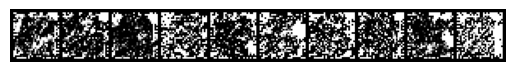

Training:   2%|▏         | 469/23500 [00:35<26:34, 14.44it/s, epoch=2/100, loss=⠀      0.1581, lr=9.54E-04]  

Labels: tensor([9, 4, 9, 4, 1, 1, 2, 4, 7, 9], device='cuda:0')


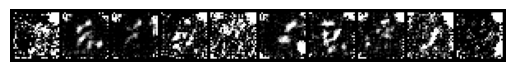

Training:   3%|▎         | 705/23500 [00:53<23:53, 15.90it/s, epoch=3/100, loss=⠀      0.0971, lr=9.32E-04]  

Labels: tensor([4, 5, 9, 9, 7, 9, 8, 2, 2, 2], device='cuda:0')


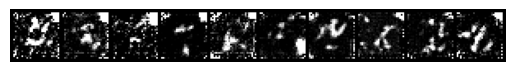

Training:   4%|▍         | 939/23500 [01:12<25:49, 14.56it/s, epoch=4/100, loss=⠀      0.0707, lr=9.10E-04]  

Labels: tensor([7, 2, 4, 0, 0, 8, 9, 3, 8, 4], device='cuda:0')


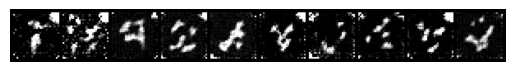

Training:   5%|▌         | 1175/23500 [01:31<23:29, 15.84it/s, epoch=5/100, loss=⠀      0.0977, lr=8.89E-04] 

Labels: tensor([1, 7, 7, 4, 6, 0, 8, 3, 7, 3], device='cuda:0')


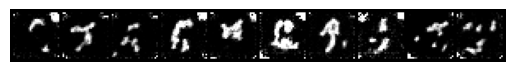

Training:   6%|▌         | 1409/23500 [01:49<24:58, 14.74it/s, epoch=6/100, loss=⠀      0.0778, lr=8.68E-04]  

Labels: tensor([0, 0, 7, 4, 5, 3, 7, 0, 5, 6], device='cuda:0')


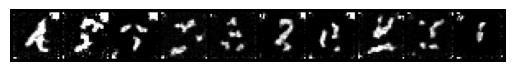

Training:   7%|▋         | 1644/23500 [02:08<24:54, 14.62it/s, epoch=7/100, loss=⠀      0.0540, lr=8.48E-04]  

Labels: tensor([9, 2, 4, 2, 2, 8, 0, 8, 9, 2], device='cuda:0')


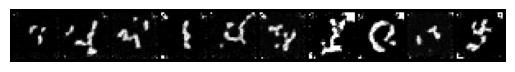

Training:   8%|▊         | 1879/23500 [02:26<24:28, 14.72it/s, epoch=8/100, loss=⠀      0.0580, lr=8.29E-04]  

Labels: tensor([5, 4, 5, 8, 8, 1, 0, 3, 4, 5], device='cuda:0')


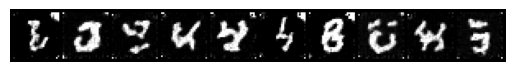

Training:   9%|▉         | 2115/23500 [02:45<22:32, 15.81it/s, epoch=9/100, loss=⠀      0.0569, lr=8.09E-04]  

Labels: tensor([3, 4, 4, 3, 2, 0, 2, 5, 1, 4], device='cuda:0')


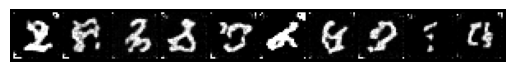

Training:  10%|▉         | 2349/23500 [03:03<23:54, 14.74it/s, epoch=10/100, loss=⠀      0.0508, lr=7.91E-04]  

Labels: tensor([0, 1, 5, 3, 1, 6, 9, 0, 9, 6], device='cuda:0')


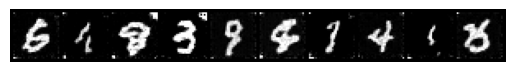

Training:  11%|█         | 2584/23500 [03:22<23:50, 14.63it/s, epoch=11/100, loss=⠀      0.0509, lr=7.72E-04]  

Labels: tensor([4, 4, 4, 9, 2, 3, 9, 8, 1, 9], device='cuda:0')


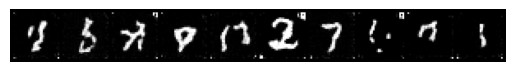

Training:  12%|█▏        | 2819/23500 [03:41<23:31, 14.65it/s, epoch=12/100, loss=⠀      0.0506, lr=7.54E-04]  

Labels: tensor([3, 4, 8, 9, 8, 8, 3, 5, 0, 7], device='cuda:0')


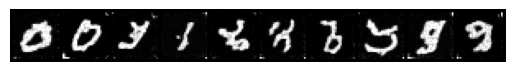

Training:  13%|█▎        | 3055/23500 [03:59<22:21, 15.24it/s, epoch=13/100, loss=⠀      0.0462, lr=7.37E-04]  

Labels: tensor([9, 4, 0, 7, 4, 0, 1, 8, 8, 3], device='cuda:0')


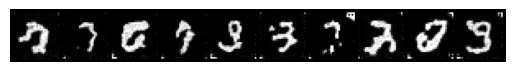

Training:  14%|█▍        | 3289/23500 [04:18<22:57, 14.67it/s, epoch=14/100, loss=⠀      0.0461, lr=7.20E-04]  

Labels: tensor([7, 7, 0, 3, 0, 4, 5, 1, 3, 4], device='cuda:0')


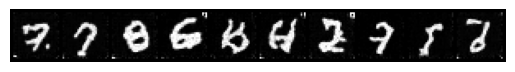

Training:  15%|█▍        | 3524/23500 [04:36<22:45, 14.63it/s, epoch=15/100, loss=⠀      0.0362, lr=7.03E-04]  

Labels: tensor([0, 1, 0, 6, 2, 8, 8, 2, 0, 9], device='cuda:0')


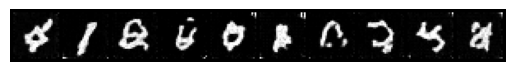

Training:  16%|█▌        | 3760/23500 [04:55<20:50, 15.79it/s, epoch=16/100, loss=⠀      0.0363, lr=6.87E-04]  

Labels: tensor([2, 0, 9, 6, 3, 6, 7, 9, 3, 2], device='cuda:0')


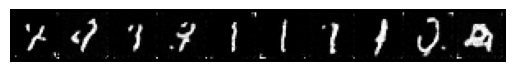

Training:  17%|█▋        | 3994/23500 [05:14<22:28, 14.47it/s, epoch=17/100, loss=⠀      0.0422, lr=6.71E-04]  

Labels: tensor([8, 9, 7, 7, 2, 5, 0, 9, 5, 1], device='cuda:0')


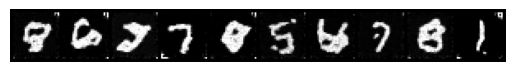

Training:  18%|█▊        | 4229/23500 [05:32<21:51, 14.69it/s, epoch=18/100, loss=⠀      0.0468, lr=6.55E-04]  

Labels: tensor([7, 6, 6, 2, 2, 9, 6, 2, 5, 8], device='cuda:0')


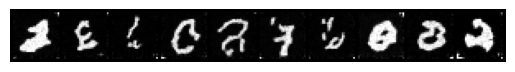

Training:  19%|█▉        | 4465/23500 [05:51<19:58, 15.88it/s, epoch=19/100, loss=⠀      0.0425, lr=6.40E-04]  

Labels: tensor([7, 0, 8, 7, 6, 0, 4, 6, 2, 1], device='cuda:0')


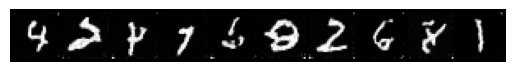

Training:  20%|█▉        | 4699/23500 [06:09<21:26, 14.61it/s, epoch=20/100, loss=⠀      0.0372, lr=6.25E-04]  

Labels: tensor([3, 3, 2, 2, 0, 5, 0, 5, 4, 7], device='cuda:0')


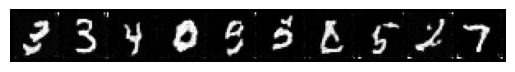

Training:  21%|██        | 4935/23500 [06:28<19:49, 15.61it/s, epoch=21/100, loss=⠀      0.0355, lr=6.10E-04]  

Labels: tensor([0, 3, 1, 9, 2, 4, 1, 8, 6, 8], device='cuda:0')


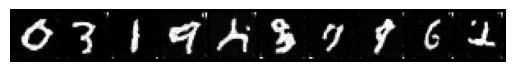

Training:  22%|██▏       | 5169/23500 [06:47<20:51, 14.64it/s, epoch=22/100, loss=⠀      0.0407, lr=5.96E-04]  

Labels: tensor([2, 5, 0, 1, 1, 9, 9, 2, 0, 8], device='cuda:0')


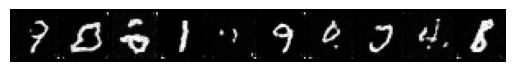

Training:  23%|██▎       | 5404/23500 [07:05<20:38, 14.61it/s, epoch=23/100, loss=⠀      0.0435, lr=5.82E-04]  

Labels: tensor([3, 9, 9, 6, 8, 7, 2, 4, 6, 0], device='cuda:0')


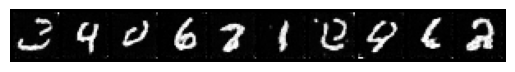

Training:  24%|██▍       | 5640/23500 [07:24<18:53, 15.75it/s, epoch=24/100, loss=⠀      0.0371, lr=5.69E-04]  

Labels: tensor([6, 3, 9, 0, 1, 6, 8, 5, 5, 9], device='cuda:0')


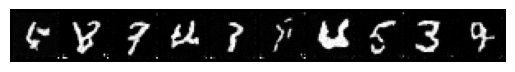

Training:  25%|██▍       | 5874/23500 [07:42<20:18, 14.46it/s, epoch=25/100, loss=⠀      0.0325, lr=5.56E-04]  

Labels: tensor([7, 9, 4, 5, 9, 0, 2, 4, 1, 1], device='cuda:0')


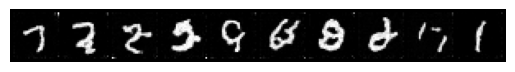

Training:  26%|██▌       | 6110/23500 [08:01<18:25, 15.73it/s, epoch=26/100, loss=⠀      0.0538, lr=5.43E-04]  

Labels: tensor([4, 8, 6, 2, 8, 5, 0, 8, 1, 9], device='cuda:0')


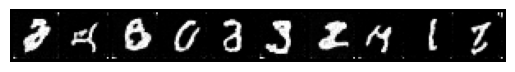

Training:  27%|██▋       | 6344/23500 [08:20<19:38, 14.56it/s, epoch=27/100, loss=⠀      0.0364, lr=5.30E-04]  

Labels: tensor([0, 2, 1, 6, 7, 0, 4, 0, 5, 1], device='cuda:0')


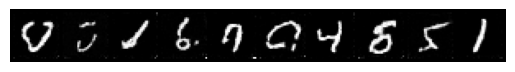

Training:  28%|██▊       | 6579/23500 [08:38<19:17, 14.62it/s, epoch=28/100, loss=⠀      0.0408, lr=5.18E-04]  

Labels: tensor([3, 6, 5, 2, 8, 4, 0, 6, 0, 2], device='cuda:0')


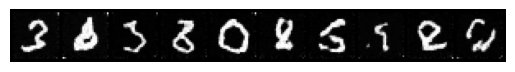

Training:  29%|██▉       | 6815/23500 [08:57<18:07, 15.35it/s, epoch=29/100, loss=⠀      0.0380, lr=5.06E-04]  

Labels: tensor([1, 9, 8, 7, 6, 3, 9, 9, 7, 3], device='cuda:0')


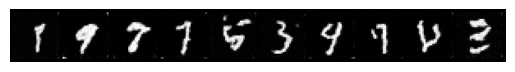

Training:  30%|██▉       | 7049/23500 [09:16<18:44, 14.62it/s, epoch=30/100, loss=⠀      0.0521, lr=4.94E-04]  

Labels: tensor([1, 7, 1, 4, 1, 0, 8, 2, 9, 0], device='cuda:0')


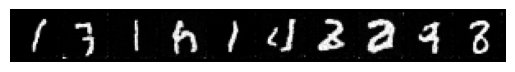

Training:  31%|███       | 7284/23500 [09:34<18:32, 14.58it/s, epoch=31/100, loss=⠀      0.0396, lr=4.83E-04]  

Labels: tensor([2, 7, 8, 6, 4, 2, 9, 7, 4, 1], device='cuda:0')


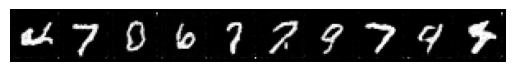

Training:  32%|███▏      | 7519/23500 [09:53<18:12, 14.63it/s, epoch=32/100, loss=⠀      0.0291, lr=4.71E-04]  

Labels: tensor([2, 6, 0, 8, 8, 9, 2, 6, 6, 3], device='cuda:0')


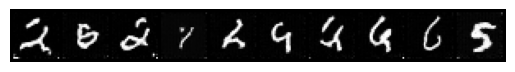

Training:  33%|███▎      | 7754/23500 [10:11<17:53, 14.66it/s, epoch=33/100, loss=⠀      0.0394, lr=4.60E-04]  

Labels: tensor([2, 0, 3, 6, 7, 3, 4, 0, 0, 5], device='cuda:0')


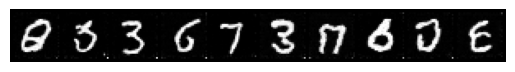

Training:  34%|███▍      | 7989/23500 [10:30<17:55, 14.42it/s, epoch=34/100, loss=⠀      0.0228, lr=4.50E-04]  

Labels: tensor([7, 5, 3, 4, 2, 7, 5, 6, 2, 9], device='cuda:0')


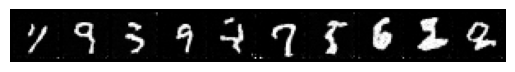

Training:  35%|███▍      | 8224/23500 [10:48<17:29, 14.55it/s, epoch=35/100, loss=⠀      0.0321, lr=4.39E-04]  

Labels: tensor([0, 3, 9, 1, 8, 4, 9, 3, 9, 8], device='cuda:0')


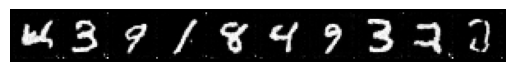

Training:  36%|███▌      | 8459/23500 [11:07<17:04, 14.68it/s, epoch=36/100, loss=⠀      0.0272, lr=4.29E-04]  

Labels: tensor([4, 5, 2, 8, 0, 5, 4, 2, 5, 8], device='cuda:0')


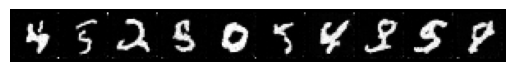

Training:  37%|███▋      | 8694/23500 [11:25<16:54, 14.59it/s, epoch=37/100, loss=⠀      0.0314, lr=4.19E-04]  

Labels: tensor([5, 2, 4, 8, 2, 6, 9, 1, 8, 7], device='cuda:0')


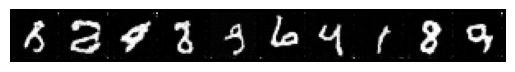

Training:  38%|███▊      | 8930/23500 [11:44<15:21, 15.82it/s, epoch=38/100, loss=⠀      0.0259, lr=4.09E-04]  

Labels: tensor([7, 7, 0, 3, 5, 0, 1, 5, 7, 6], device='cuda:0')


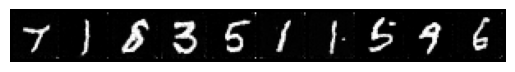

Training:  39%|███▉      | 9164/23500 [12:03<16:21, 14.61it/s, epoch=39/100, loss=⠀      0.0342, lr=4.00E-04]  

Labels: tensor([5, 7, 9, 9, 1, 7, 6, 0, 1, 4], device='cuda:0')


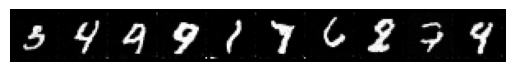

Training:  40%|███▉      | 9399/23500 [12:21<15:58, 14.72it/s, epoch=40/100, loss=⠀      0.0300, lr=3.91E-04]  

Labels: tensor([4, 6, 9, 2, 5, 2, 4, 3, 4, 8], device='cuda:0')


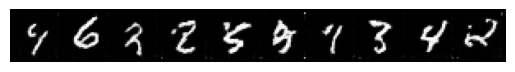

Training:  41%|████      | 9634/23500 [12:40<15:48, 14.63it/s, epoch=41/100, loss=⠀      0.0310, lr=3.82E-04]  

Labels: tensor([0, 8, 4, 3, 2, 6, 4, 6, 9, 0], device='cuda:0')


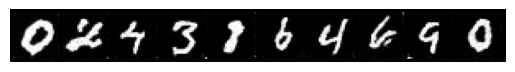

Training:  42%|████▏     | 9869/23500 [12:58<15:24, 14.74it/s, epoch=42/100, loss=⠀      0.0374, lr=3.73E-04]  

Labels: tensor([1, 7, 1, 4, 4, 6, 9, 6, 3, 0], device='cuda:0')


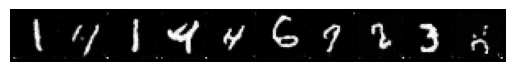

Training:  43%|████▎     | 10105/23500 [13:17<14:01, 15.91it/s, epoch=43/100, loss=⠀      0.0284, lr=3.64E-04] 

Labels: tensor([3, 8, 1, 1, 1, 1, 9, 7, 6, 5], device='cuda:0')


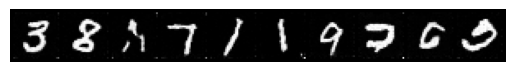

Training:  44%|████▍     | 10339/23500 [13:35<15:04, 14.55it/s, epoch=44/100, loss=⠀      0.0391, lr=3.56E-04]  

Labels: tensor([6, 3, 5, 6, 9, 9, 8, 7, 8, 9], device='cuda:0')


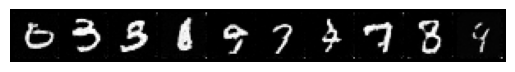

Training:  45%|████▌     | 10575/23500 [13:54<13:33, 15.90it/s, epoch=45/100, loss=⠀      0.0322, lr=3.47E-04]  

Labels: tensor([7, 2, 0, 3, 2, 1, 0, 8, 9, 2], device='cuda:0')


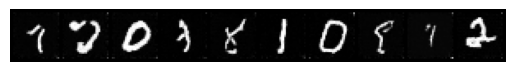

Training:  46%|████▌     | 10809/23500 [14:13<14:16, 14.82it/s, epoch=46/100, loss=⠀      0.0372, lr=3.39E-04]  

Labels: tensor([6, 1, 7, 0, 2, 5, 4, 8, 5, 2], device='cuda:0')


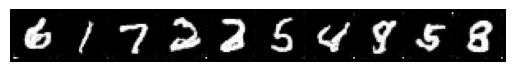

Training:  47%|████▋     | 11044/23500 [14:31<14:04, 14.76it/s, epoch=47/100, loss=⠀      0.0313, lr=3.31E-04]  

Labels: tensor([7, 7, 7, 1, 5, 1, 3, 4, 2, 6], device='cuda:0')


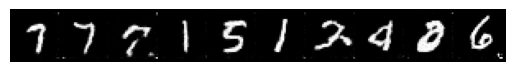

Training:  48%|████▊     | 11279/23500 [14:49<13:41, 14.87it/s, epoch=48/100, loss=⠀      0.0452, lr=3.24E-04]  

Labels: tensor([8, 5, 6, 4, 6, 0, 9, 6, 8, 1], device='cuda:0')


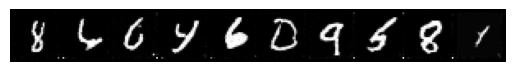

Training:  49%|████▉     | 11514/23500 [15:07<13:14, 15.09it/s, epoch=49/100, loss=⠀      0.0327, lr=3.16E-04]  

Labels: tensor([7, 9, 6, 6, 3, 3, 4, 9, 9, 9], device='cuda:0')


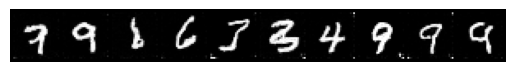

Training:  50%|████▉     | 11749/23500 [15:26<13:15, 14.77it/s, epoch=50/100, loss=⠀      0.0295, lr=3.09E-04]  

Labels: tensor([3, 2, 6, 3, 1, 6, 3, 4, 5, 9], device='cuda:0')


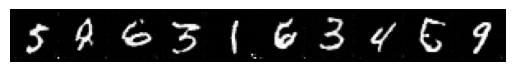

Training:  51%|█████     | 11984/23500 [15:44<13:05, 14.66it/s, epoch=51/100, loss=⠀      0.0365, lr=3.02E-04]  

Labels: tensor([1, 2, 1, 6, 1, 1, 0, 1, 7, 8], device='cuda:0')


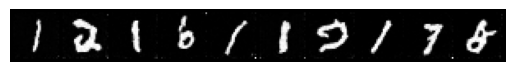

Training:  52%|█████▏    | 12220/23500 [16:03<11:46, 15.96it/s, epoch=52/100, loss=⠀      0.0253, lr=2.95E-04]  

Labels: tensor([4, 7, 3, 2, 7, 7, 1, 2, 8, 8], device='cuda:0')


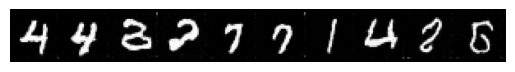

Training:  53%|█████▎    | 12454/23500 [16:21<12:33, 14.66it/s, epoch=53/100, loss=⠀      0.0256, lr=2.88E-04]  

Labels: tensor([9, 4, 3, 2, 1, 0, 3, 4, 1, 6], device='cuda:0')


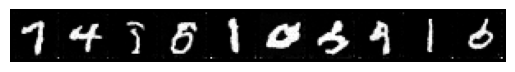

Training:  54%|█████▍    | 12689/23500 [16:40<12:08, 14.84it/s, epoch=54/100, loss=⠀      0.0337, lr=2.81E-04]  

Labels: tensor([0, 6, 7, 0, 6, 1, 8, 3, 7, 2], device='cuda:0')


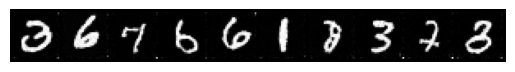

Training:  55%|█████▍    | 12924/23500 [16:58<12:01, 14.66it/s, epoch=55/100, loss=⠀      0.0258, lr=2.75E-04]  

Labels: tensor([3, 2, 8, 5, 9, 3, 3, 4, 6, 0], device='cuda:0')


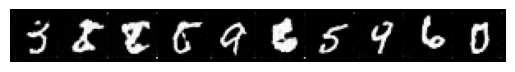

Training:  56%|█████▌    | 13159/23500 [17:16<11:37, 14.84it/s, epoch=56/100, loss=⠀      0.0237, lr=2.68E-04]  

Labels: tensor([7, 6, 0, 8, 1, 0, 8, 7, 6, 2], device='cuda:0')


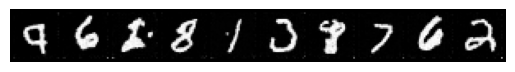

Training:  57%|█████▋    | 13394/23500 [17:35<11:27, 14.70it/s, epoch=57/100, loss=⠀      0.0386, lr=2.62E-04]  

Labels: tensor([8, 2, 7, 1, 6, 4, 8, 1, 9, 9], device='cuda:0')


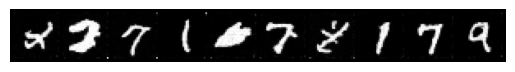

Training:  58%|█████▊    | 13629/23500 [17:53<11:03, 14.88it/s, epoch=58/100, loss=⠀      0.0349, lr=2.56E-04]  

Labels: tensor([4, 8, 2, 6, 3, 1, 2, 7, 2, 6], device='cuda:0')


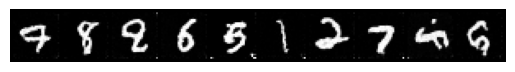

Training:  59%|█████▉    | 13865/23500 [18:11<10:07, 15.86it/s, epoch=59/100, loss=⠀      0.0318, lr=2.50E-04]  

Labels: tensor([0, 1, 4, 1, 2, 3, 9, 4, 7, 9], device='cuda:0')


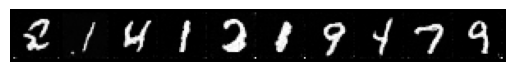

Training:  60%|█████▉    | 14099/23500 [18:30<10:32, 14.86it/s, epoch=60/100, loss=⠀      0.0303, lr=2.44E-04]  

Labels: tensor([8, 7, 8, 7, 1, 6, 4, 8, 2, 3], device='cuda:0')


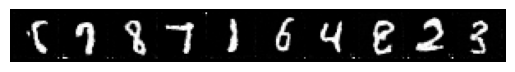

Training:  61%|██████    | 14334/23500 [18:48<10:23, 14.70it/s, epoch=61/100, loss=⠀      0.0300, lr=2.38E-04]  

Labels: tensor([1, 9, 2, 8, 3, 7, 2, 6, 4, 1], device='cuda:0')


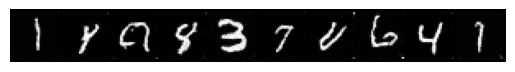

Training:  62%|██████▏   | 14569/23500 [19:07<10:06, 14.73it/s, epoch=62/100, loss=⠀      0.0241, lr=2.33E-04]

Labels: tensor([3, 3, 8, 5, 9, 5, 2, 7, 8, 9], device='cuda:0')


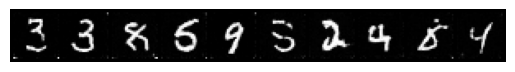

Training:  63%|██████▎   | 14804/23500 [19:25<09:52, 14.69it/s, epoch=63/100, loss=⠀      0.0309, lr=2.28E-04]

Labels: tensor([5, 1, 7, 6, 2, 2, 0, 1, 3, 0], device='cuda:0')


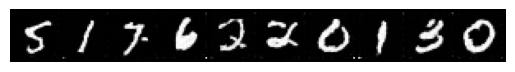

Training:  64%|██████▍   | 15039/23500 [19:44<09:31, 14.80it/s, epoch=64/100, loss=⠀      0.0279, lr=2.22E-04]

Labels: tensor([1, 9, 0, 3, 0, 6, 6, 3, 2, 3], device='cuda:0')


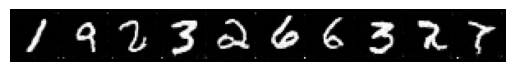

Training:  65%|██████▍   | 15274/23500 [20:02<09:20, 14.69it/s, epoch=65/100, loss=⠀      0.0301, lr=2.17E-04]

Labels: tensor([8, 1, 8, 6, 0, 8, 7, 7, 5, 4], device='cuda:0')


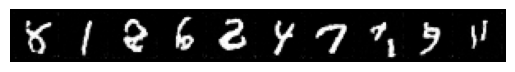

Training:  66%|██████▌   | 15509/23500 [20:20<08:55, 14.94it/s, epoch=66/100, loss=⠀      0.0365, lr=2.12E-04]

Labels: tensor([1, 1, 0, 4, 9, 1, 7, 8, 6, 4], device='cuda:0')


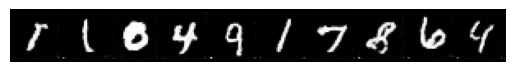

Training:  67%|██████▋   | 15744/23500 [20:38<08:38, 14.97it/s, epoch=67/100, loss=⠀      0.0382, lr=2.07E-04]

Labels: tensor([9, 6, 2, 0, 1, 0, 6, 8, 8, 8], device='cuda:0')


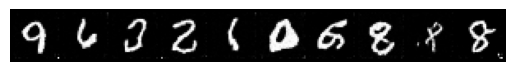

Training:  68%|██████▊   | 15979/23500 [20:57<08:24, 14.91it/s, epoch=68/100, loss=⠀      0.0280, lr=2.02E-04]

Labels: tensor([4, 9, 9, 5, 2, 1, 8, 7, 3, 3], device='cuda:0')


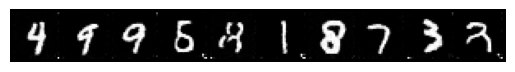

Training:  69%|██████▉   | 16214/23500 [21:15<08:07, 14.94it/s, epoch=69/100, loss=⠀      0.0363, lr=1.98E-04]

Labels: tensor([4, 4, 0, 9, 3, 7, 5, 2, 3, 4], device='cuda:0')


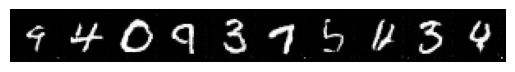

Training:  70%|██████▉   | 16449/23500 [21:33<07:50, 14.97it/s, epoch=70/100, loss=⠀      0.0279, lr=1.93E-04]

Labels: tensor([7, 7, 9, 4, 7, 1, 3, 1, 5, 3], device='cuda:0')


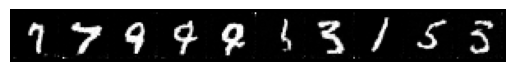

Training:  71%|███████   | 16684/23500 [21:51<07:43, 14.69it/s, epoch=71/100, loss=⠀      0.0254, lr=1.89E-04]

Labels: tensor([3, 6, 9, 1, 1, 8, 6, 1, 6, 5], device='cuda:0')


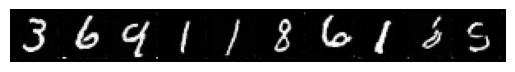

Training:  72%|███████▏  | 16919/23500 [22:10<07:23, 14.83it/s, epoch=72/100, loss=⠀      0.0269, lr=1.84E-04]

Labels: tensor([5, 5, 7, 8, 4, 8, 7, 2, 7, 4], device='cuda:0')


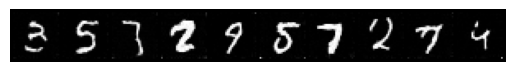

Training:  73%|███████▎  | 17154/23500 [22:28<07:01, 15.04it/s, epoch=73/100, loss=⠀      0.0266, lr=1.80E-04]

Labels: tensor([4, 3, 1, 4, 8, 2, 5, 8, 6, 9], device='cuda:0')


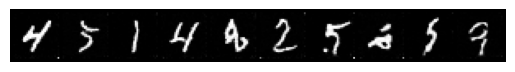

Training:  74%|███████▍  | 17389/23500 [22:46<06:31, 15.62it/s, epoch=74/100, loss=⠀      0.0308, lr=1.76E-04]

Labels: tensor([1, 3, 4, 3, 1, 2, 3, 9, 5, 2], device='cuda:0')


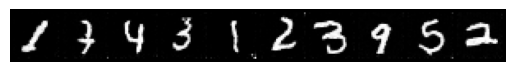

Training:  75%|███████▍  | 17624/23500 [23:04<06:21, 15.40it/s, epoch=75/100, loss=⠀      0.0374, lr=1.72E-04]

Labels: tensor([1, 5, 5, 4, 7, 5, 9, 0, 7, 1], device='cuda:0')


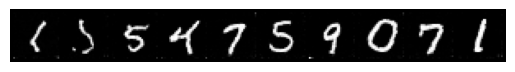

Training:  76%|███████▌  | 17859/23500 [23:22<06:11, 15.17it/s, epoch=76/100, loss=⠀      0.0331, lr=1.68E-04]

Labels: tensor([0, 5, 7, 8, 0, 7, 5, 1, 1, 7], device='cuda:0')


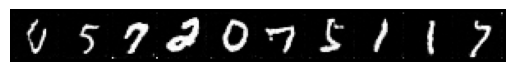

Training:  77%|███████▋  | 18094/23500 [23:39<05:46, 15.62it/s, epoch=77/100, loss=⠀      0.0285, lr=1.64E-04]

Labels: tensor([9, 0, 5, 8, 2, 2, 5, 4, 6, 5], device='cuda:0')


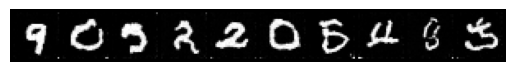

Training:  78%|███████▊  | 18329/23500 [23:57<05:30, 15.62it/s, epoch=78/100, loss=⠀      0.0334, lr=1.60E-04]

Labels: tensor([5, 3, 3, 5, 5, 9, 8, 0, 9, 4], device='cuda:0')


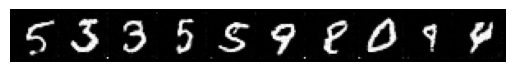

Training:  79%|███████▉  | 18564/23500 [24:15<05:18, 15.49it/s, epoch=79/100, loss=⠀      0.0293, lr=1.56E-04]

Labels: tensor([1, 3, 5, 9, 0, 0, 8, 8, 7, 5], device='cuda:0')


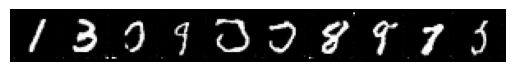

Training:  80%|███████▉  | 18799/23500 [24:33<05:12, 15.05it/s, epoch=80/100, loss=⠀      0.0315, lr=1.53E-04]

Labels: tensor([3, 1, 7, 5, 0, 4, 7, 2, 6, 8], device='cuda:0')


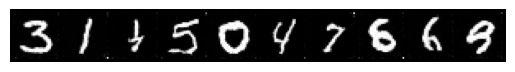

Training:  81%|████████  | 19034/23500 [24:51<05:00, 14.86it/s, epoch=81/100, loss=⠀      0.0325, lr=1.49E-04]

Labels: tensor([5, 9, 7, 6, 9, 7, 9, 6, 9, 5], device='cuda:0')


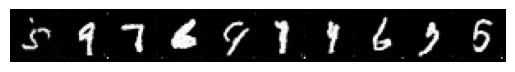

Training:  82%|████████▏ | 19269/23500 [25:09<04:43, 14.93it/s, epoch=82/100, loss=⠀      0.0309, lr=1.46E-04]

Labels: tensor([9, 3, 1, 6, 5, 0, 7, 8, 4, 5], device='cuda:0')


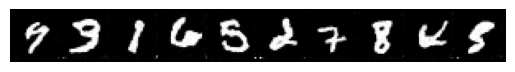

Training:  83%|████████▎ | 19504/23500 [25:28<04:24, 15.11it/s, epoch=83/100, loss=⠀      0.0290, lr=1.42E-04]

Labels: tensor([5, 6, 0, 7, 4, 8, 2, 8, 8, 7], device='cuda:0')


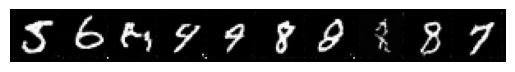

Training:  84%|████████▍ | 19739/23500 [25:45<03:59, 15.72it/s, epoch=84/100, loss=⠀      0.0291, lr=1.39E-04]

Labels: tensor([9, 8, 8, 1, 8, 4, 1, 3, 9, 4], device='cuda:0')


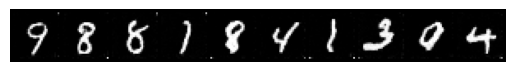

Training:  85%|████████▍ | 19974/23500 [26:04<03:53, 15.09it/s, epoch=85/100, loss=⠀      0.0229, lr=1.36E-04]

Labels: tensor([7, 0, 4, 3, 1, 2, 0, 1, 5, 6], device='cuda:0')


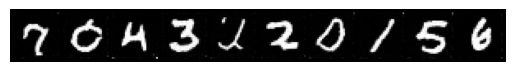

Training:  86%|████████▌ | 20209/23500 [26:21<03:31, 15.59it/s, epoch=86/100, loss=⠀      0.0261, lr=1.33E-04]

Labels: tensor([0, 1, 6, 6, 8, 5, 0, 5, 6, 0], device='cuda:0')


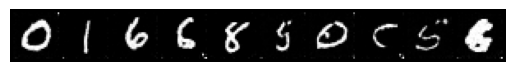

Training:  87%|████████▋ | 20444/23500 [26:40<03:20, 15.21it/s, epoch=87/100, loss=⠀      0.0284, lr=1.29E-04]

Labels: tensor([8, 9, 9, 2, 8, 9, 4, 8, 2, 3], device='cuda:0')


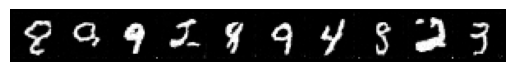

Training:  88%|████████▊ | 20679/23500 [26:57<02:59, 15.70it/s, epoch=88/100, loss=⠀      0.0298, lr=1.26E-04]

Labels: tensor([3, 8, 5, 4, 2, 0, 2, 7, 1, 7], device='cuda:0')


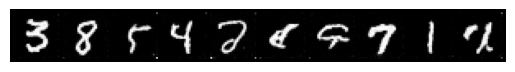

Training:  89%|████████▉ | 20914/23500 [27:16<02:56, 14.63it/s, epoch=89/100, loss=⠀      0.0327, lr=1.23E-04]

Labels: tensor([4, 2, 8, 7, 4, 1, 9, 3, 3, 1], device='cuda:0')


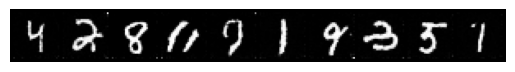

Training:  90%|████████▉ | 21149/23500 [27:34<02:39, 14.77it/s, epoch=90/100, loss=⠀      0.0365, lr=1.21E-04]

Labels: tensor([4, 7, 0, 7, 6, 2, 9, 5, 8, 2], device='cuda:0')


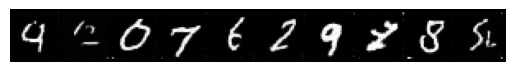

Training:  91%|█████████ | 21384/23500 [27:52<02:24, 14.64it/s, epoch=91/100, loss=⠀      0.0257, lr=1.18E-04]

Labels: tensor([2, 5, 6, 8, 4, 4, 5, 3, 8, 9], device='cuda:0')


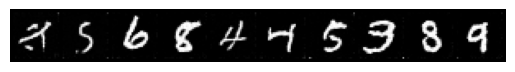

Training:  92%|█████████▏| 21619/23500 [28:11<02:07, 14.70it/s, epoch=92/100, loss=⠀      0.0289, lr=1.15E-04]

Labels: tensor([3, 8, 1, 3, 4, 1, 3, 5, 7, 4], device='cuda:0')


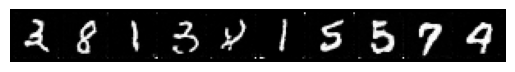

Training:  93%|█████████▎| 21855/23500 [28:30<01:43, 15.91it/s, epoch=93/100, loss=⠀      0.0243, lr=1.12E-04]

Labels: tensor([6, 3, 7, 3, 9, 3, 3, 2, 9, 0], device='cuda:0')


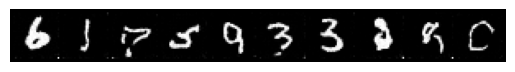

Training:  94%|█████████▍| 22089/23500 [28:48<01:35, 14.73it/s, epoch=94/100, loss=⠀      0.0341, lr=1.10E-04]

Labels: tensor([1, 9, 7, 7, 0, 6, 3, 8, 0, 3], device='cuda:0')


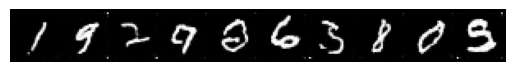

Training:  95%|█████████▌| 22325/23500 [29:07<01:13, 15.91it/s, epoch=95/100, loss=⠀      0.0283, lr=1.07E-04]

Labels: tensor([1, 6, 7, 8, 0, 0, 5, 2, 2, 1], device='cuda:0')


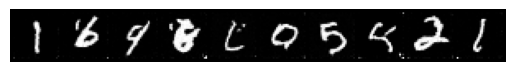

Training:  96%|█████████▌| 22559/23500 [29:25<01:04, 14.65it/s, epoch=96/100, loss=⠀      0.0261, lr=1.05E-04]

Labels: tensor([3, 1, 8, 1, 9, 2, 5, 4, 8, 2], device='cuda:0')


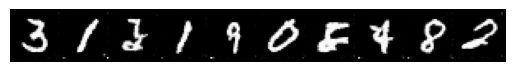

Training:  97%|█████████▋| 22795/23500 [29:44<00:45, 15.56it/s, epoch=97/100, loss=⠀      0.0259, lr=1.02E-04]

Labels: tensor([2, 7, 6, 2, 0, 1, 7, 9, 0, 3], device='cuda:0')


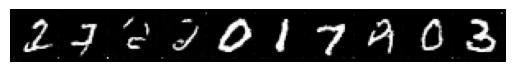

Training:  98%|█████████▊| 23029/23500 [30:02<00:31, 14.76it/s, epoch=98/100, loss=⠀      0.0209, lr=9.99E-05]

Labels: tensor([5, 1, 1, 8, 9, 9, 0, 4, 5, 0], device='cuda:0')


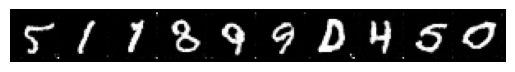

Training:  99%|█████████▉| 23264/23500 [30:21<00:16, 14.63it/s, epoch=99/100, loss=⠀      0.0239, lr=9.76E-05]

Labels: tensor([5, 9, 2, 6, 7, 9, 3, 4, 4, 9], device='cuda:0')


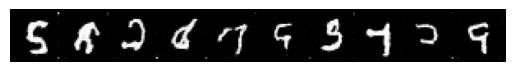

Training: 100%|█████████▉| 23499/23500 [30:39<00:00, 14.71it/s, epoch=100/100, loss=⠀      0.0365, lr=9.54E-05]

Labels: tensor([0, 4, 6, 5, 5, 0, 9, 0, 9, 4], device='cuda:0')


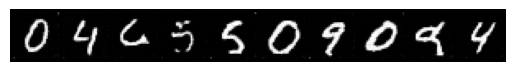

Training: 100%|██████████| 23500/23500 [30:42<00:00, 12.76it/s, epoch=100/100, loss=⠀      0.0365, lr=9.54E-05]


AttributeError: Can't pickle local object 'ScoreNet.__init__.<locals>.<lambda>'

In [ ]:
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2, num_classes=10, class_emb_size=4):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1 
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """
        
        super(DDPM, self).__init__()
        
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t, y: (self._network(x.reshape(-1, 1, 28, 28), 
                                                   (t.squeeze()/T), y)
                                    ).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))
        

    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon. 
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index 
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        ''' 
        
        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])
        
        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon, y):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t, y)) 
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)
        
        return mean + std*epsilon

    
    @torch.no_grad()
    def sample(self, shape, y=None):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image            
        """
        if y is None:
            # Sample random classes
            y = torch.randint(0, 10, (shape[0],), device=self.beta.device)
            print(f"Labels: {y}")
        else:
            y = torch.tensor([y], device=self.beta.device).expand((shape[0],))
        
        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)            
            xt = self.reverse_diffusion(xt, t, noise, y)

        return xt

    
    def elbo_simple(self, x0, y):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value            
        """

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)
        
        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)
        
        return -nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t, y))

    
    def loss(self, x0, y):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0, y).mean()


def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    """
    Training loop
    
    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)                
    
    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        global_step_counter = 0
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            loss = model.loss(x, y)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter%ema_steps==0:
                    ema_model.update_parameters(model)                
        
        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)


# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020, 
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model = DDPM(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


def reporter(model):
    """Callback function used for plotting images during training"""
    
    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples,28*28), None).cpu()
        
        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2 
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()    

# Call training loop
train(model, optimizer, scheduler, dataloader_train, 
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)

In [5]:
torch.save(model.state_dict(), "./model.pth")

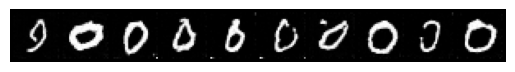

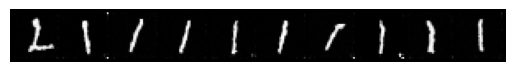

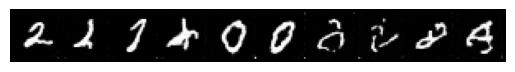

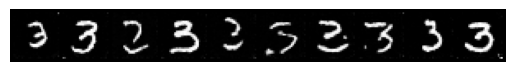

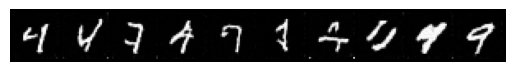

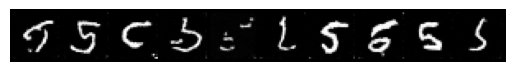

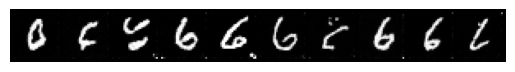

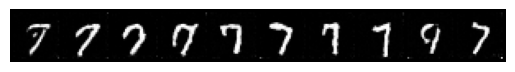

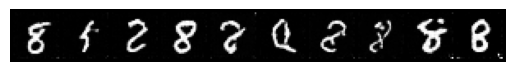

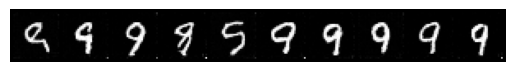

In [9]:
nsamples = 10
# Sample for each digit
for i in range(0, 10):
      samples = model.sample((nsamples,28*28), i).cpu()
    # Map pixel values back from [-1,1] to [0,1]
      samples = (samples+1)/2 
      samples = samples.clamp(0.0, 1.0)

      # Plot in grid
      grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
      plt.gca().set_axis_off()
      plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
      plt.savefig(f"{i}.png", bbox_inches="tight", pad_inches=0)  
      plt.show()